## Predicting Toxicity from a 2D Molecular Structure (WORK IN PROGRESS)

[introduction to script, aims, method, outcome]

[RDKit image to CNN input image](https://www.cheminformania.com/learn-how-to-teach-your-computer-to-see-chemistry-free-chemception-models-with-rdkit-and-keras/)
used chemcepterize_mol function from this site by Esben J. Bjerrum.

[Chemception paper](https://arxiv.org/abs/1706.06689)
Goh, Garrett B., Charles Siegel, Abhinav Vishnu, Nathan O. Hodas, and Nathan Baker. "Chemception: a deep neural network with minimal chemistry knowledge matches the performance of expert-developed QSAR/QSPR models." arXiv preprint arXiv:1706.06689 (2017).

[CNN guide from MNIST dataset](https://www.kaggle.com/code/tcmaso/mnist-guide-cnn-augmentation-tuning-99-5)

additoinal notes:
- image gives no indication of atom, stereochemistry or bond order of bonds

1. **Introduction**
1.1 Abstract
1.2 Libraries
2. **Data preparation and pre-processing**
2.1 Loading data
2.2 Checking for missing values
2.3 Creating inputs
2.4 Data visualizations
2.5 Creating training and validation sets
2.6 Pre-processing pipelines
2.7 Custom f1, recall and precision metrics
3. **Building network and training**
3.1 Building network
3.2 Training network
3.3 Validation results
3.4 Review of incorrectly classified examples
3.5 Visualizing filters and feature-maps
4. **Data augmentation**
4.1 Creating an ImageDataGenerator
4.2 Augmented images visualized
4.3 Training network on augmented data
4.4 Validation results on augmented data
5. **Hyper-parameter tuning**
5.1 Building hyper-parameter model
5.2 Hyper-parameter search (using HyperBand)
5.3 Hyper-parameter results
6. **Ensembling**
6.1 Ensembling top models from hyper-parameter tuning
6.2 Voting classifier function and results
6.3 Ensembling on best model
7. **Conclusion**
7.1 Results summary

**1.1 Abstract**

[abstract]

**1.2 Libraries**

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

from sklearn.model_selection import train_test_split
from tensorflow import keras

In [2]:
# np.random.seed()

## Data preparation and pre-processing

[what is the tox21 dataset?]

**2.1 Loading data**

In [3]:
df = pd.read_csv('tox21_data.csv')
print(df.shape)
df.head()

(7817, 14)


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


**2.2 Check for missing data**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7817 entries, 0 to 7816
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   NR-AR          7251 non-null   float64
 1   NR-AR-LBD      6745 non-null   float64
 2   NR-AhR         6537 non-null   float64
 3   NR-Aromatase   5809 non-null   float64
 4   NR-ER          6181 non-null   float64
 5   NR-ER-LBD      6941 non-null   float64
 6   NR-PPAR-gamma  6437 non-null   float64
 7   SR-ARE         5826 non-null   float64
 8   SR-ATAD5       7058 non-null   float64
 9   SR-HSE         6460 non-null   float64
 10  SR-MMP         5802 non-null   float64
 11  SR-p53         6761 non-null   float64
 12  mol_id         7817 non-null   object 
 13  smiles         7817 non-null   object 
dtypes: float64(12), object(2)
memory usage: 855.1+ KB


In [5]:
num_nan = sum([True for idx,row in df.iterrows() if any(row.isnull())])
print(f'{num_nan}/{df.shape[0]} ({100*num_nan/df.shape[0]:.1f}%) rows contain NaNs. This is a considerable number but we will deal with this when we calculate toxicity below.')

4739/7817 (60.6%) rows contain NaNs. This is a considerable number but we will deal with this when we calculate toxicity below.


**2.3 Creating Inputs**

In [6]:
# classify whether each molecule is considered toxic across all categories
df['toxic'] = np.where(df.loc[:,'NR-AR':'SR-p53'].sum(axis=1)==0, 0, 1)

# if the molecule is toxic, then we ignore any NaNs in this row as, regardless of the NaNs actual value, the molecule is still toxic
toxic = df[df['toxic']==1]

# if the molecule is not toxic, we drop any rows containing NaNs as these may have contained 1s (i.e. indicated toxic)
nontoxic = df[df['toxic']==0]
nontoxic.dropna(inplace=True)

# recombine dataframes
df = pd.concat([toxic, nontoxic]).reset_index(drop=True)
print(f'tox21 dataset has {df.shape[0]} molecules, {toxic.shape[0]} ({100*toxic.shape[0]/df.shape[0]:.1f}%) of which are classified as toxic.')

tox21 dataset has 5269 molecules, 2867 (54.4%) of which are classified as toxic.


c:\users\erw\appdata\local\programs\python\python39\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


This has the added bonus of giving us an approx. 50:50 split.

In [7]:
df['molecule'] = df['smiles'].apply(Chem.MolFromSmiles)

In [8]:
# modified code from Esben J. Bjerrum
def mol_to_greyscale(mol, embed=20.0, res=0.5):

    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims, dims, 1))

    #Bonds first
    for i, bond in enumerate(mol.GetBonds()):

        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0, 1, int(1/res*2))

        for f in frac:
            c = (f * bcoords + (1 - f) * ecoords)
            idx = int(round((c[0] + embed) / res))
            idy = int(round((c[1] + embed) / res))
            vect[idx, idy, 0] = bondorder

    # Atoms second
    for i, atom in enumerate(cmol.GetAtoms()):
        idx = int(round((coords[i][0] + embed) / res))
        idy = int(round((coords[i][1] + embed) / res))
        # Atomic number
        vect[idx, idy, 0] = atom.GetAtomicNum()

    return vect

def vectorise(mol, embed=19, res=0.4):
    return mol_to_greyscale(mol, embed, res)

this is strange, most molecules i'm looking at don't get anywhere close to filling the frame. How can I change this?

(95, 95, 1)


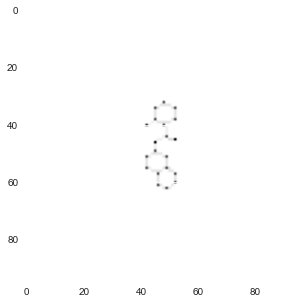

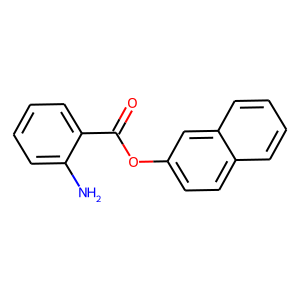

In [9]:
mol = df["molecule"][15]
v = mol_to_greyscale(mol, embed=19, res=0.4)
print(v.shape)

fig, ax = plt.subplots(figsize=(10,5))
plt.imshow(v, cmap='Greys')

plt.show()

Draw.MolToImage(mol)

In [10]:
%%time
df['image'] = df['molecule'].map(vectorise)
df = df[['smiles', 'molecule', 'image', 'toxic']]
df.head()

Wall time: 21.4 s


,smiles,molecule,image,toxic
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,<rdkit.Chem.rdchem.Mol object at 0x0000027C87D...,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1
1,O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1,<rdkit.Chem.rdchem.Mol object at 0x0000027C87D...,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1
2,Cl/C=C\C[N+]12CN3CN(CN(C3)C1)C2,<rdkit.Chem.rdchem.Mol object at 0x0000027C87D...,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1
3,O=C([O-])Cc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x0000027C87D...,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1
4,CCOc1ccc(S(=O)(=O)O)c2cccnc12,<rdkit.Chem.rdchem.Mol object at 0x0000027C87D...,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1


**2.4 Data Visualisations**

set of all different atoms present in data set

In [11]:
from collections import Counter

atoms_lst = []
for idx, mol in df.molecule.iteritems():
    a = list(set(atom.GetAtomicNum() for atom in mol.GetAtoms()))
    for _ in a:
        atoms_lst.append(_)

atoms = Counter(atoms_lst)
atoms

Counter({8: 4314,
         16: 857,
         6: 5215,
         7: 2909,
         53: 46,
         17: 864,
         9: 361,
         15: 154,
         35: 133,
         14: 44,
         29: 5,
         80: 12,
         5: 20,
         24: 3,
         50: 19,
         56: 3,
         81: 1,
         12: 2,
         23: 1,
         27: 2,
         82: 1,
         51: 2,
         26: 5,
         49: 1,
         83: 1,
         48: 2,
         79: 3,
         30: 6,
         25: 2,
         13: 6,
         33: 7,
         78: 3,
         34: 3,
         11: 6,
         32: 1,
         20: 3,
         19: 3,
         42: 1,
         70: 1,
         3: 1,
         28: 1,
         40: 1})

In [12]:
elements = {3:'Li', 5:'B', 6:'C', 7:'N', 8:'O', 9:'F', 11:'Na',
            12:'Mg', 13:'Al', 14:'Si', 15:'P', 16:'S', 17:'Cl',
            19:'K', 20:'Ca', 23:'V', 24:'Cr', 25:'Mn', 26:'Fe',
            27:'Co', 28:'Ni', 29:'Cu', 30:'Zn', 32:'Ge', 33:'As',
            34:'Se', 35:'Br', 40:'Zr', 42:'Mo', 48:'Cd', 49:'In',
            50:'Sn', 51:'Sb', 53:'I', 56:'Ba', 70:'Yb', 78:'Pt',
            79:'Au', 80:'Hg', 81:'Tl', 82:'Pb', 83:'Bi'}

In [13]:
combined = {}
for atomic_num, count in atoms.items():
    combined[ elements[atomic_num] ] = (atomic_num, count)
combined

{'O': (8, 4314),
 'S': (16, 857),
 'C': (6, 5215),
 'N': (7, 2909),
 'I': (53, 46),
 'Cl': (17, 864),
 'F': (9, 361),
 'P': (15, 154),
 'Br': (35, 133),
 'Si': (14, 44),
 'Cu': (29, 5),
 'Hg': (80, 12),
 'B': (5, 20),
 'Cr': (24, 3),
 'Sn': (50, 19),
 'Ba': (56, 3),
 'Tl': (81, 1),
 'Mg': (12, 2),
 'V': (23, 1),
 'Co': (27, 2),
 'Pb': (82, 1),
 'Sb': (51, 2),
 'Fe': (26, 5),
 'In': (49, 1),
 'Bi': (83, 1),
 'Cd': (48, 2),
 'Au': (79, 3),
 'Zn': (30, 6),
 'Mn': (25, 2),
 'Al': (13, 6),
 'As': (33, 7),
 'Pt': (78, 3),
 'Se': (34, 3),
 'Na': (11, 6),
 'Ge': (32, 1),
 'Ca': (20, 3),
 'K': (19, 3),
 'Mo': (42, 1),
 'Yb': (70, 1),
 'Li': (3, 1),
 'Ni': (28, 1),
 'Zr': (40, 1)}

[plot of occurence vs element - to do]

**2.5 Train, Test and Validation Sets**

In [14]:
# I will train with separate training (80%), validation (10%) and testing (10%) sets.

train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

# train is now 80% of the entire data set
img_train, img_test, tox_train, tox_test = train_test_split(df['image'], df['toxic'], test_size=1 - train_ratio, stratify=df['toxic'])

# test is now 10% of the initial data set
# validation is now 10% of the initial data set
img_val, img_test, tox_val, tox_test= train_test_split(img_test, tox_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify=tox_test)

total = df['toxic'].shape[0]

print(f' Training set: {tox_train.shape[0]} molecules ({100*tox_train.shape[0]/total:.0f}%)\n'
      f' Validation set: {tox_val.shape[0]} molecules ({100*tox_val.shape[0]/total:.0f}%)\n'
      f' Testing set: {tox_test.shape[0]} molecules ({100*tox_test.shape[0]/total:.0f}%)')

 Training set: 4215 molecules (80%)
 Validation set: 527 molecules (10%)
 Testing set: 527 molecules (10%)


In [15]:
print(tox_train.sum(), tox_val.sum(), tox_test.sum())

2293 287 287


In [16]:
df.image[0].shape

(95, 95, 1)

In [17]:
#reshape data to fit model
img_train = np.stack(img_train)  # (4215, 95, 95, 1)
img_test = np.stack(img_test)  # (527, 95, 95, 1)
img_val = np.stack(img_val)  # (527, 95, 95, 1)

In [18]:
# StandardScaler is used here as the vast majority of atoms are light (e.g. C, O, N) with a few much heavier atoms (e.g. I, Au, Pb).
img_train = (img_train - img_train.mean()) / img_train.std()
img_test = (img_test - img_train.mean()) / img_train.std()
img_val = (img_val - img_train.mean()) / img_train.std()

In [19]:
# correctly format toxicity values (np.array instead of pd.Series)
tox_train = np.array(tox_train)
tox_test = np.array(tox_test)
tox_val = np.array(tox_val)

In [20]:
# from Thomas Mason
from keras import backend as K

# Precision (using keras backend)
def precision_metric(y_true, y_pred):
    threshold = 0.5  # Training threshold 0.5
    y_pred_y = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())

    true_positives = K.sum(K.clip(y_true * y_pred, 0, 1))
    false_negatives = K.sum(K.clip(y_true * (1-y_pred), 0, 1))
    false_positives = K.sum(K.clip((1-y_true) * y_pred, 0, 1))
    true_negatives = K.sum(K.clip((1 - y_true) * (1-y_pred), 0, 1))

    precision = true_positives / (true_positives + false_positives + K.epsilon())
    return precision

# Recall (using keras backend)
def recall_metric(y_true, y_pred):
    threshold = 0.5 #Training threshold 0.5
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())

    true_positives = K.sum(K.clip(y_true * y_pred, 0, 1))
    false_negatives = K.sum(K.clip(y_true * (1-y_pred), 0, 1))
    false_positives = K.sum(K.clip((1-y_true) * y_pred, 0, 1))
    true_negatives = K.sum(K.clip((1 - y_true) * (1-y_pred), 0, 1))

    recall = true_positives / (true_positives + false_negatives + K.epsilon())
    return recall

# F1-score (using keras backend)
def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (recall+precision+K.epsilon()))
    return f1

## 3. Build network and training

[info about LeNet and an image of final layers structure]

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout

def build_model():

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding='SAME', activation='relu', input_shape=(95, 95, 1)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(5,5), padding='SAME', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.BinaryCrossentropy(),
                  optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=['binary_accuracy', f1_metric, recall_metric, precision_metric])

    return model

In [22]:
model= build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 95, 95, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 47, 47, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0

3.2 Training Network

In [23]:
%%time
history = model.fit(img_train, tox_train,
                    validation_data=(img_val, tox_val),
                    epochs=40,
                    batch_size=32,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                             mode='min',
                                                             patience=10,
                                                             min_delta=0.005,
                                                             restore_best_weights=True),
                               keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                                 patience = 3)
                               ]
                    )

Epoch 1/40
132/132 [==============================] - 114s 834ms/step - loss: 0.7479 - binary_accuracy: 0.6415 - f1_metric: 0.6221 - recall_metric: 0.6798 - precision_metric: 0.6028 - val_loss: 0.8076 - val_binary_accuracy: 0.4554 - val_f1_metric: 0.0000e+00 - val_recall_metric: 0.0000e+00 - val_precision_metric: 0.5772 - lr: 1.0000e-04
Epoch 2/40
132/132 [==============================] - 115s 874ms/step - loss: 0.6435 - binary_accuracy: 0.6752 - f1_metric: 0.6616 - recall_metric: 0.7384 - precision_metric: 0.6130 - val_loss: 1.0752 - val_binary_accuracy: 0.4554 - val_f1_metric: 0.0000e+00 - val_recall_metric: 0.0000e+00 - val_precision_metric: 0.6043 - lr: 1.0000e-04
Epoch 3/40
132/132 [==============================] - 114s 864ms/step - loss: 0.6161 - binary_accuracy: 0.6833 - f1_metric: 0.6667 - recall_metric: 0.7407 - precision_metric: 0.6186 - val_loss: 1.0005 - val_binary_accuracy: 0.4611 - val_f1_metric: 0.0271 - val_recall_metric: 0.0158 - val_precision_metric: 0.6298 - lr: 1.

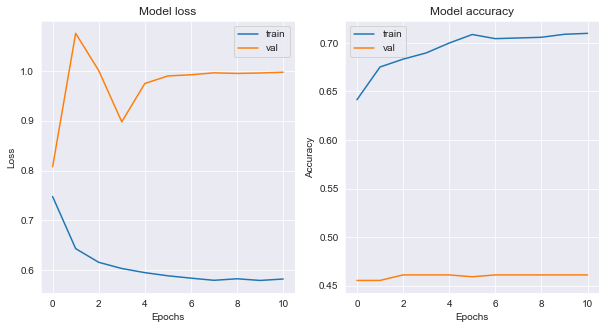

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

ax1 = ax[0]
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='val')
ax1.set_title('Model loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2 = ax[1]
ax2.plot(history.history['binary_accuracy'], label='train')
ax2.plot(history.history['val_binary_accuracy'], label='val')
ax2.set_title('Model accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [25]:
tox_test_pred = model.predict(img_test)
test_results = pd.DataFrame({'toxic':tox_test, 'model_1': tox_test_pred.flatten()})

17/17 [==============================] - 3s 126ms/step


In [26]:
test_results

,toxic,model_1
0,1,0.280979
1,0,0.272234
2,1,0.294763
3,0,0.275964
4,1,0.282114
...,...,...
522,1,0.376496
523,1,0.308499
524,1,0.292702
525,0,0.267515


In [27]:
model.save('models\model_1')

INFO:tensorflow:Assets written to: models\model_1\assets


INFO:tensorflow:Assets written to: models\model_1\assets


Validation Results

In [28]:
tox_val_pred = model.predict(img_val)
tox_val_pred.max()

17/17 [==============================] - 2s 109ms/step


0.48691395

Text(34.0, 0.5, 'True')

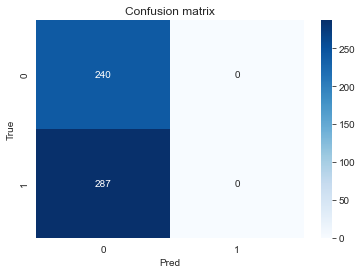

In [29]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(tox_val, tox_val_pred.flatten().round())
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion matrix')
plt.xlabel('Pred')
plt.ylabel('True')

# 4. Data Augmentation

[code in this section not yet working]

In [30]:
from keras.preprocessing.image import ImageDataGenerator

In [31]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range = 0.10,
)

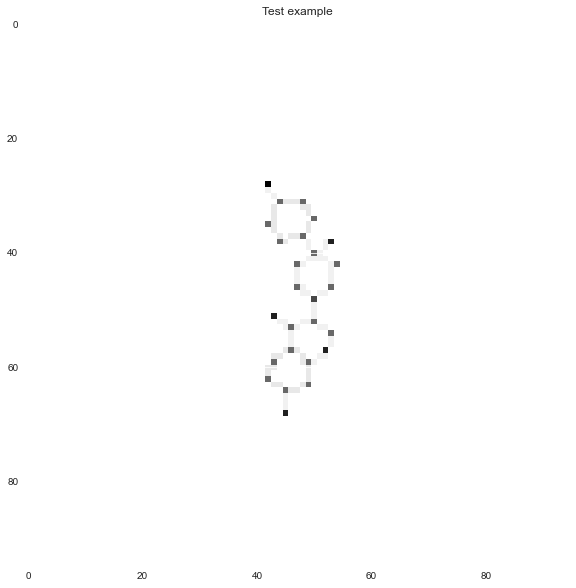

In [32]:
temp_example_X = img_train[100]
temp_example_y = tox_train[100]
plt.figure(figsize=(10,10))
plt.title('Test example')
plt.imshow(temp_example_X.squeeze(), cmap='Greys')

TypeError: object of type 'numpy.int32' has no len()

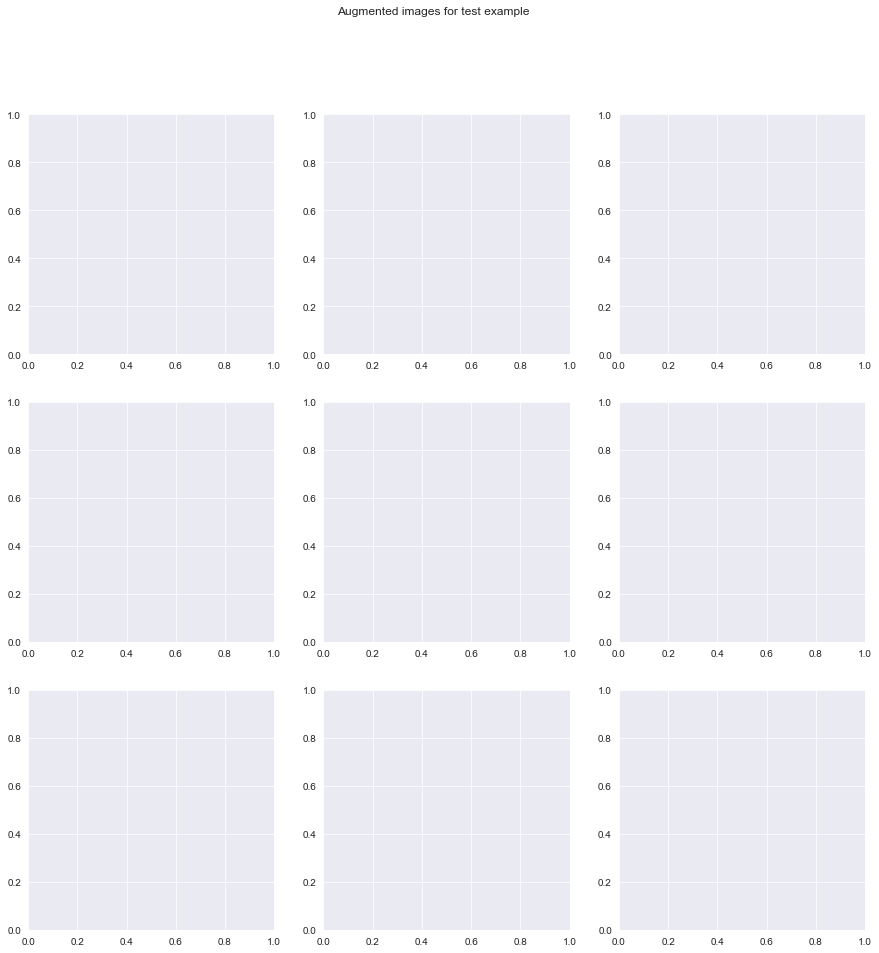

In [33]:
fig, axes = plt.subplots(3, 3, figsize=(15,15))
fig.suptitle('Augmented images for test example')
for i in range(3):
    for j in range(3):
        augmented_example_X, augmented_example_y = datagen.flow(temp_example_X, temp_example_y, batch_size=1).next()
        axes[i,j].imshow(augmented_example_X.squeeze(), cmap='Greys')
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

In [ ]:
model2 = build_model()

In [ ]:
train_generator = datagen.flow(img_train, tox_train, batch_size=32)

In [ ]:
steps_per_epoch = train_generator.n // train_generator.batch_size

In [ ]:
%%time
history2 = model2.fit(train_generator,
                      validation_data=(img_val, tox_val),
                      epochs=40,
                      steps_per_epoch=steps_per_epoch,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                               mode='min',
                                                               patience=10,
                                                               min_delta=0.005,
                                                               restore_best_weights=True),
                                 keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                                   patience = 3)
                                 ]
                      )

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

ax1 = ax[0]
ax1.plot(history2.history['loss'], label='train')
ax1.plot(history2.history['val_loss'], label='val')
ax1.set_title('Model loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2 = ax[1]
ax2.plot(history2.history['binary_accuracy'], label='train')
ax2.plot(history2.history['val_binary_accuracy'], label='val')
ax2.set_title('Model accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()